# Developing "Momentum" Trading Strategy
* Many differnt takes on this strategy
* Sometimes referred to as trend following
* Whatever you do and call it, you first need to research potential trading signals

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf


### 1. Download data: 
* Many services for this, some paid some free 
* Yahoo Finance API
* Typically trading "systems" involve a number of securities
* For this demonstration we are just going to look at GLD --> the gold ETF

In [6]:
ticker = yf.Ticker("GLD")
gld = ticker.history(period="max")
day = np.arange(1, len(gld)+1)
gld['day'] = day
gld.drop(columns=['Volume', 'Dividends', 'Stock Splits', 'Capital Gains'], inplace=True)
gld = gld[['day', 'Open', 'High', 'Low', 'Close']]
gld.head()

,day,Open,High,Low,Close
Date,,,,,
2004-11-18 00:00:00-05:00,1,44.430000,44.490002,44.070000,44.380001
2004-11-19 00:00:00-05:00,2,44.490002,44.919998,44.470001,44.779999
2004-11-22 00:00:00-05:00,3,44.750000,44.970001,44.740002,44.950001
2004-11-23 00:00:00-05:00,4,44.880001,44.919998,44.720001,44.750000
2004-11-24 00:00:00-05:00,5,44.930000,45.049999,44.790001,45.049999


In [7]:
gld.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4963 entries, 2004-11-18 00:00:00-05:00 to 2024-08-08 00:00:00-04:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   day     4963 non-null   int32  
 1   Open    4963 non-null   float64
 2   High    4963 non-null   float64
 3   Low     4963 non-null   float64
 4   Close   4963 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 213.3 KB


### 2. Add data/transform data
* calculate signal based on some price or statistical action
* we are going to try a moving average crossover to generate signals
* for this strategy we will always by "in" a trade, either long or short
* we are modeling; this means real life variation should be expected

#### Add moving averages to the data frame

In [21]:
gld['9-day'] = gld['Close'].rolling(9).mean().shift()
gld['21-day'] = gld['Close'].rolling(21).mean().shift()
gld[19:25]

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2005-01-14 00:00:00-05:00,40,42.189999,42.320000,42.130001,42.320000,42.420000,NaN,-1,-0.006594,0.006594,0.0
2005-01-18 00:00:00-05:00,41,42.220001,42.380001,42.150002,42.320000,42.342222,NaN,-1,0.000000,-0.000000,0.0
2005-01-19 00:00:00-05:00,42,42.650002,42.650002,42.200001,42.259998,42.295555,43.219048,-1,-0.001419,0.001419,0.0
2005-01-20 00:00:00-05:00,43,42.119999,42.320000,42.110001,42.250000,42.250000,43.127143,-1,-0.000237,0.000237,0.0
2005-01-21 00:00:00-05:00,44,42.320000,42.820000,42.290001,42.740002,42.261111,43.027619,-1,0.011531,-0.011531,0.0
2005-01-24 00:00:00-05:00,45,42.740002,42.820000,42.669998,42.770000,42.361111,42.957143,-1,0.000702,-0.000702,0.0


#### Add "signal" column  

In [22]:
gld['signal'] = np.where(gld['9-day'] > gld['21-day'], 1, 0)
gld['signal'] = np.where(gld['9-day'] < gld['21-day'], -1, gld['signal'])
gld.dropna(inplace=True)
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2005-01-19 00:00:00-05:00,42,42.650002,42.650002,42.200001,42.259998,42.295555,43.219048,-1,-0.001419,0.001419,0.0
2005-01-20 00:00:00-05:00,43,42.119999,42.320000,42.110001,42.250000,42.250000,43.127143,-1,-0.000237,0.000237,0.0
2005-01-21 00:00:00-05:00,44,42.320000,42.820000,42.290001,42.740002,42.261111,43.027619,-1,0.011531,-0.011531,0.0
2005-01-24 00:00:00-05:00,45,42.740002,42.820000,42.669998,42.770000,42.361111,42.957143,-1,0.000702,-0.000702,0.0
2005-01-25 00:00:00-05:00,46,42.529999,42.560001,42.099998,42.240002,42.452222,42.897619,-1,-0.012469,0.012469,0.0


#### Calculate Instantaneous returns/system returns

In [23]:
gld['return'] = np.log(gld['Close']).diff()
gld['system_return'] = gld['signal'] * gld['return']
gld['entry'] = gld.signal.diff()
gld.head()

,day,Open,High,Low,Close,9-day,21-day,signal,return,system_return,entry
Date,,,,,,,,,,,
2005-01-19 00:00:00-05:00,42,42.650002,42.650002,42.200001,42.259998,42.295555,43.219048,-1,NaN,NaN,NaN
2005-01-20 00:00:00-05:00,43,42.119999,42.320000,42.110001,42.250000,42.250000,43.127143,-1,-0.000237,0.000237,0.0
2005-01-21 00:00:00-05:00,44,42.320000,42.820000,42.290001,42.740002,42.261111,43.027619,-1,0.011531,-0.011531,0.0
2005-01-24 00:00:00-05:00,45,42.740002,42.820000,42.669998,42.770000,42.361111,42.957143,-1,0.000702,-0.000702,0.0
2005-01-25 00:00:00-05:00,46,42.529999,42.560001,42.099998,42.240002,42.452222,42.897619,-1,-0.012469,0.012469,0.0


#### Plot trades on time series

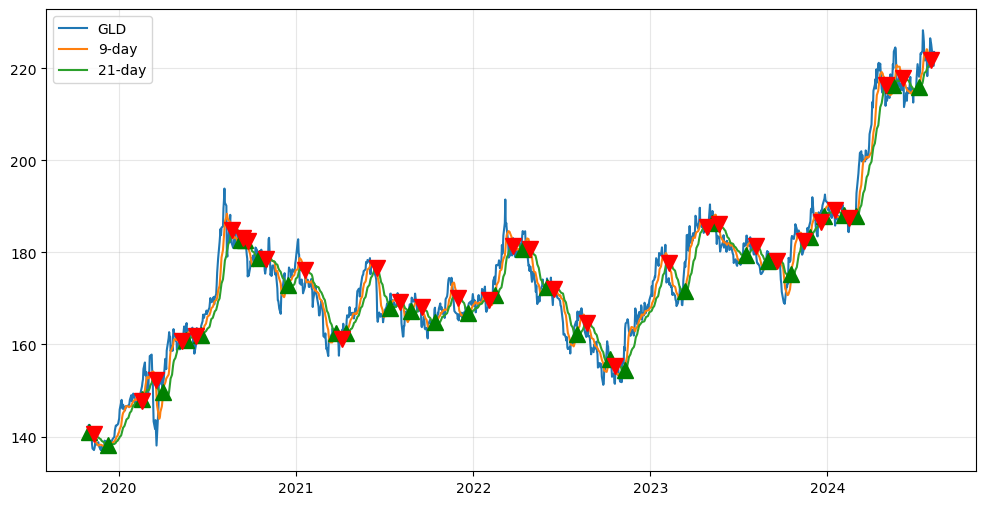

In [24]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(gld.iloc[-1200:]['Close'], label = 'GLD')
plt.plot(gld.iloc[-1200:]['9-day'], label = '9-day')
plt.plot(gld.iloc[-1200:]['21-day'], label = '21-day')
plt.plot(gld[-1200:].loc[gld.entry == 2].index, gld[-1200:]['9-day'][gld.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(gld[-1200:].loc[gld.entry == -2].index, gld[-1200:]['21-day'][gld.entry == -2], 'v',
         color = 'r', markersize = 12)
plt.legend(loc=2);

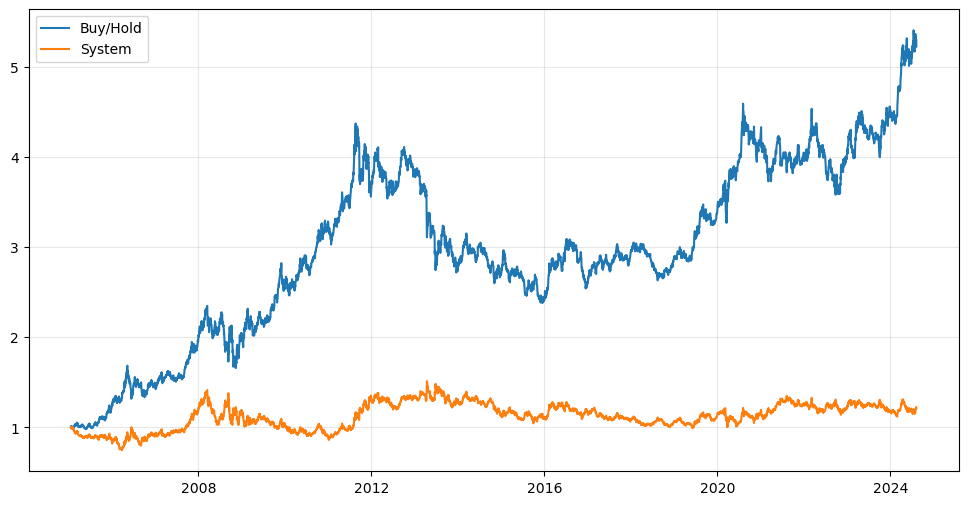

In [25]:
plt.plot(np.exp(gld['return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(gld['system_return']).cumprod(), label='System')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [26]:
np.exp(gld['return']).cumprod()[-1] -1

C:\Users\jsullij9\AppData\Local\Temp\ipykernel_12924\3657817252.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld['return']).cumprod()[-1] -1


4.290582364200711

In [27]:
np.exp(gld['system_return']).cumprod()[-1] -1

C:\Users\jsullij9\AppData\Local\Temp\ipykernel_12924\4188747400.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(gld['system_return']).cumprod()[-1] -1


0.20772855380374922